In [45]:
import os
import json
import pandas as pd
import torch
from datetime import datetime
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData

path = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder\score.json"
records = []

with open(path, "r", encoding="utf-8") as f:

    data = json.load(f)

    for entry in data:

        speech_id  = entry["id"]
        tone_score = entry['gpt-5']

        for topic, score in tone_score.items():
            records.append({
                "speech_id": speech_id,
                "topic": topic,
                "tone_score": score
            })

df = pd.DataFrame(records)
df["tone_norm"] = df.groupby("topic")["tone_score"].transform(
    lambda x: (x - x.mean()) / x.std()
)
df.head()

,speech_id,topic,tone_score,tone_norm
0,feddsp:95906,Fed Funds Rate,0.0,-0.201565
1,feddsp:95906,Labor Market,0.0,-0.387294
2,feddsp:95906,Inflation,0.0,-0.525486
3,feddsp:95906,Real Activity,0.0,-0.351968
4,feddsp:95906,Financial Stability,-0.5,-2.117084


In [72]:
speech_texts = {}
text_data_folder = r"C:\Users\MainUser\project\cs224w_cb_graph\text_data"
speakers = []
speech_dates = {}
speakers_by_ids = {}


for filename in os.listdir(text_data_folder):
    if not filename.endswith(".json"):
        continue
    path = os.path.join(text_data_folder, filename)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for entry in data:
        speech_id = entry["id"]
        speech_texts[speech_id] = entry.get("text", "")
        speakers += [entry["author"]]
        speech_dates[speech_id] = datetime.strptime(entry["date"], "%Y-%m-%d")
        speakers_by_ids[speech_id] = entry["author"]

speakers = list(set(speakers))


In [73]:
embedder   = SentenceTransformer("all-MiniLM-L6-v2")
speech_ids = list(speech_texts.keys())
speech_embeddings = (
    embedder.encode([speech_texts[i] for i in speech_ids], normalize_embeddings=True))

unique_topics = sorted(df["topic"].unique())
topic_embeddings = embedder.encode(unique_topics, normalize_embeddings=True)
speakers_embeddings = embedder.encode(speakers, normalize_embeddings=True)

print(f"\nGenerated \n"
      f"{len(speech_embeddings)} speech embeddings \n"
      f"{len(speakers_embeddings)} speaker embeddings \n"
      f"{len(topic_embeddings)} topic embeddings.")


Generated 
55 speech embeddings 
2 speaker embeddings 
6 topic embeddings.


In [89]:
data = HeteroData()

data["speech"].x = torch.tensor(speech_embeddings, dtype=torch.float)
data["topic"].x = torch.tensor(topic_embeddings, dtype=torch.float)
data["speaker"].x = torch.tensor(speakers_embeddings, dtype=torch.float)

speech_to_idx = {sid: i for i, sid in enumerate(speech_ids)}
topic_to_idx = {t: i for i, t in enumerate(unique_topics)}
speaker_to_idx = {s: i for i, s in enumerate(speakers)}

edge_index = []
edge_attr = []

for _, row in df.iterrows():
    s_idx = speech_to_idx[row["speech_id"]]
    t_idx = topic_to_idx[row["topic"]]
    edge_index.append([s_idx, t_idx])
    edge_attr.append([row["tone_norm"]])

speech_sorted = sorted(speech_dates.items(), key=lambda x: x[1])
temporal_edges = []

time_diffs = []
for i in range(len(speech_sorted) - 1):
    src = speech_to_idx[speech_sorted[i][0]]
    dst = speech_to_idx[speech_sorted[i + 1][0]]
    temporal_edges.append([src, dst])

speech_speaker_edges = []

for speech_id, author_name in speakers_by_ids.items():

    s_idx = speech_to_idx[speech_id]
    sp_idx = speaker_to_idx[author_name]
    speech_speaker_edges.append([s_idx, sp_idx])

speech_speaker_edges = torch.tensor(speech_speaker_edges, dtype=torch.long).t().contiguous()
temporal_edges = torch.tensor(temporal_edges, dtype=torch.long).t().contiguous()
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)


temporal_pairs = temporal_edges.t().tolist()

time_diffs = []
for src, dst in temporal_pairs:
    src_id = list(speech_to_idx.keys())[list(speech_to_idx.values()).index(src)]
    dst_id = list(speech_to_idx.keys())[list(speech_to_idx.values()).index(dst)]
    delta_days = (speech_dates[dst_id] - speech_dates[src_id]).days
    time_diffs.append(delta_days)

import numpy as np
time_diffs = np.array(time_diffs, dtype=float)
print(len(time_diffs))

data["speech", "discusses", "topic"].edge_index = edge_index
data["speech", "discusses", "topic"].edge_attr = edge_attr
data["speech", "follows", "speech"].edge_index = temporal_edges
data["speech", "follows", "speech"].edge_attr = torch.tensor(time_diffs, dtype=torch.float).unsqueeze(1)
data["speaker", "authored", "speech"].edge_index = speech_speaker_edges


54


In [90]:
print(data)
print("Node types:", data.node_types)
print("Edge types:", data.edge_types)

print("Speech–Topic edges:", data["speech", "discusses", "topic"].edge_index.shape)
print("Speech–Speech temporal edges:", data["speech", "follows", "speech"].edge_index.shape)
print("Speech–Speech temporal edges:", data["speech", "follows", "speech"].edge_attr.shape)
print("Speech–Speaker edges:", data["speaker", "authored", "speech"].edge_index.shape)

HeteroData(
  speech={ x=[55, 384] },
  topic={ x=[6, 384] },
  speaker={ x=[2, 384] },
  (speech, discusses, topic)={
    edge_index=[2, 306],
    edge_attr=[306, 1],
  },
  (speech, follows, speech)={
    edge_index=[2, 54],
    edge_attr=[54, 1],
  },
  (speaker, authored, speech)={ edge_index=[2, 55] }
)
Node types: ['speech', 'topic', 'speaker']
Edge types: [('speech', 'discusses', 'topic'), ('speech', 'follows', 'speech'), ('speaker', 'authored', 'speech')]
Speech–Topic edges: torch.Size([2, 306])
Speech–Speech temporal edges: torch.Size([2, 54])
Speech–Speech temporal edges: torch.Size([54, 1])
Speech–Speaker edges: torch.Size([2, 55])


In [91]:
result_folder = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder"
torch.save(data, os.path.join(result_folder, "fed_speech_graph.pt"))

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Initialize Graph ---
G = nx.DiGraph()

# Add nodes with colors by type
for i in range(data['speech'].num_nodes):
    G.add_node(f"S_{i}", node_type="speech", color="skyblue")

for i in range(data['topic'].num_nodes):
    G.add_node(f"T_{i}", node_type="topic", color="salmon")

for i in range(data['speaker'].num_nodes):
    G.add_node(f"P_{i}", node_type="speaker", color="lightgreen")


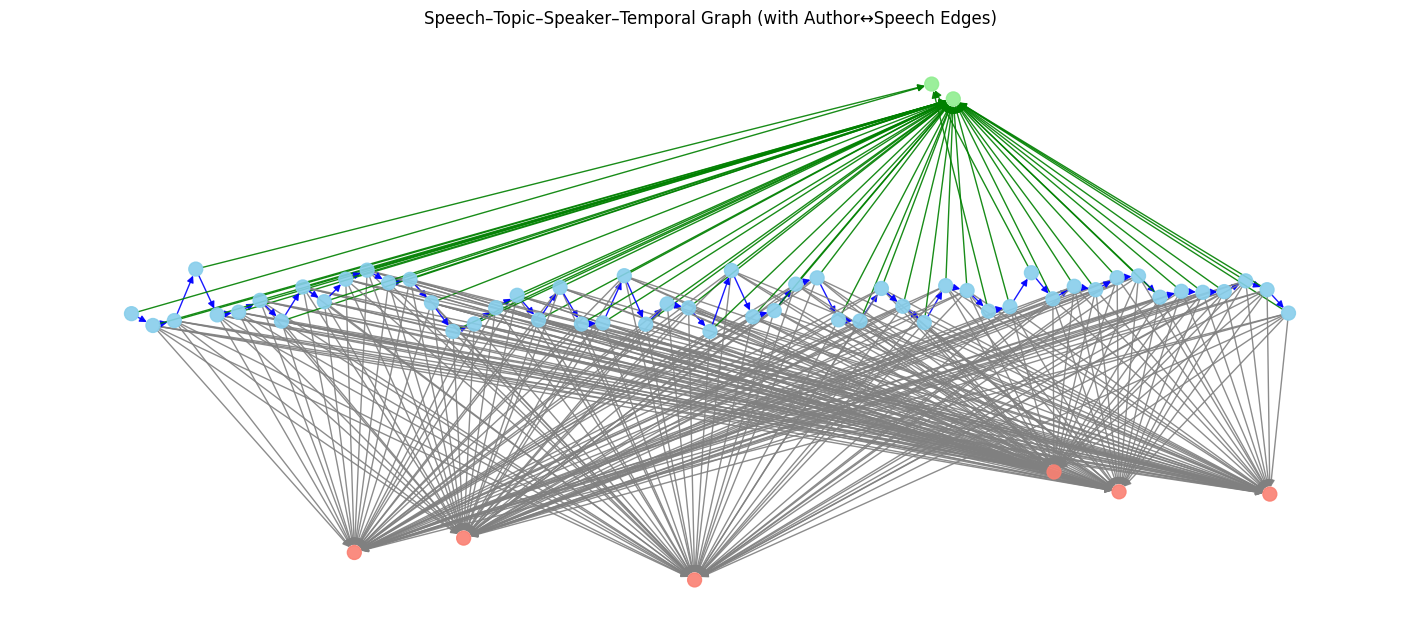

In [97]:

# --- 2. Add edges ---
# Speech–Topic edges
for src, dst in data['speech', 'discusses', 'topic'].edge_index.t().tolist():
    G.add_edge(f"S_{src}", f"T_{dst}", color="gray")

# Temporal edges (Speech→Speech)
for src, dst in data['speech', 'follows', 'speech'].edge_index.t().tolist():
    G.add_edge(f"S_{src}", f"S_{dst}", color="blue")


for src, dst in data['speaker', 'authored', 'speech'].edge_index.t().tolist():
    G.add_edge(f"S_{src}", f"P_{dst}", color="green")


speech_ids = list(speech_dates.keys())
dates = pd.Series(speech_dates).sort_values()
date_to_x = {sid: i for i, sid in enumerate(dates.index)}  # chronological order

pos = {}
# Speech nodes: along the x-axis (timeline)
for sid in speech_ids:
    if sid in date_to_x:
        x = date_to_x[sid]
        y = np.random.uniform(-0.2, 0.2)
        pos[f"S_{speech_to_idx[sid]}"] = (x, y)

# Topic nodes: below
for i in range(data['topic'].num_nodes):
    pos[f"T_{i}"] = (np.random.uniform(0, len(dates)), np.random.uniform(-2, -1))

# Speaker nodes: above
for i in range(data['speaker'].num_nodes):
    pos[f"P_{i}"] = (np.random.uniform(0, len(dates)), np.random.uniform(1, 2))

# --- 4. Draw graph ---
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
node_colors = [G.nodes[n].get('color', 'red') for n in G.nodes()]

plt.figure(figsize=(14, 6))
nx.draw(
    G, pos,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=100,
    with_labels=False,
    arrows=True,
    alpha=0.9
)
plt.title("Speech–Topic–Speaker–Temporal Graph (with Author↔Speech Edges)")
plt.xlabel("Time → (chronological order of speeches)")
plt.ylabel("Node layers: Topics ↓ / Speeches / Speakers ↑")
plt.show()
